In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.table import Table, join
import numpy as np
from astropy import units as u
from astropy.units import photometric
from IPython.display import set_matplotlib_formats


In [22]:
plt.rcParams['figure.figsize'] = (20, 10)
set_matplotlib_formats('svg')

In [3]:
def load_catalog(path):
    t = Table.read(path, hdu=1)
    for flux in [flux for flux in t.colnames if flux.startswith('FLUX_')]:
        band = '_'.join(flux.split('_')[1:])
        t[f'MAG_AB_{band}'] = (t[flux] * u.uJy).to(u.mag(photometric.AB))
    return t

In [4]:
def labelled_histo(data, title=None, bins=None, stats=False):
    plt.figure()
    b = plt.hist(data, bins=bins)
    bin_counts = b[0]
    bin_edges = b[1]
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    for count, center in zip(bin_counts, bin_centers):
        if count:
            plt.text(center, count, f'{int(count)}', horizontalalignment='center')
    if stats:
        plt.annotate(f'$\mu$: {np.mean(data):.4f}\n$\sigma$: {np.std(data):.4f}', xy=(0.05, 0.95), xycoords='axes fraction')
    if title:
        plt.title(title)
    plt.show()

In [18]:
def compare(pruned_path, not_pruned_path):
    pruned = load_catalog(pruned_path)
    not_pruned = load_catalog(not_pruned_path)
       
    # VIS cut
    mag_vis_cut = np.logical_and(pruned['MAG_AB_VIS'] >= 17, pruned['MAG_AB_VIS'] <= 24.5)
    pruned = pruned[mag_vis_cut]
    not_pruned = not_pruned[mag_vis_cut]
    
    assert (not_pruned['ID'] == pruned['ID']).all()
    
    # Absolute number of matching neighbors
    match = np.full(pruned['NEIGHBOR_IDS'].shape, True)
    for i in range(len(pruned)):
        match[i,:] = np.isin(pruned[i]['NEIGHBOR_IDS'], not_pruned[i]['NEIGHBOR_IDS'])
    match_count = match.sum(axis=1)
    
    labelled_histo(match_count, title='Matching neighbors', bins=np.arange(-0.5, 31.5))
    
    # Sorted by weight
    pruned_ids_sorted = np.take_along_axis(pruned['NEIGHBOR_IDS'], np.flip(pruned['NEIGHBOR_WEIGHTS'].argsort(axis=1)), axis=1)
    not_pruned_ids_sorted = np.take_along_axis(not_pruned['NEIGHBOR_IDS'], np.flip(not_pruned['NEIGHBOR_WEIGHTS'].argsort(axis=1)), axis=1)
    match_in_order = (pruned_ids_sorted == not_pruned_ids_sorted).sum(axis=1)
    
    labelled_histo(match_in_order, title='Matching neighbors (sorted by weight)', bins=np.arange(-0.5, 31.5))
    
    match_w = np.isclose(pruned['NEIGHBOR_WEIGHTS'], not_pruned['NEIGHBOR_WEIGHTS']).sum(axis=1)
    labelled_histo(match_w, title='Matching weights', stats=True, bins=np.arange(-0.5, 31.5))
    
    # Redshift mode
    diff_median = pruned['REDSHIFT_MEDIAN'] - not_pruned['REDSHIFT_MEDIAN']
    md = np.max(np.abs(diff_median))
    labelled_histo(diff_median, title='Photo-Z median difference', bins=np.linspace(-md,md,20), stats=True)
    
    # Redshift median
    diff_mode = pruned['REDSHIFT_MODE'] - not_pruned['REDSHIFT_MODE']
    md = np.max(np.abs(diff_mode))
    labelled_histo(diff_mode, title='Photo-Z mode difference', bins=np.linspace(-md,md,20), stats=True)

# Lognorm

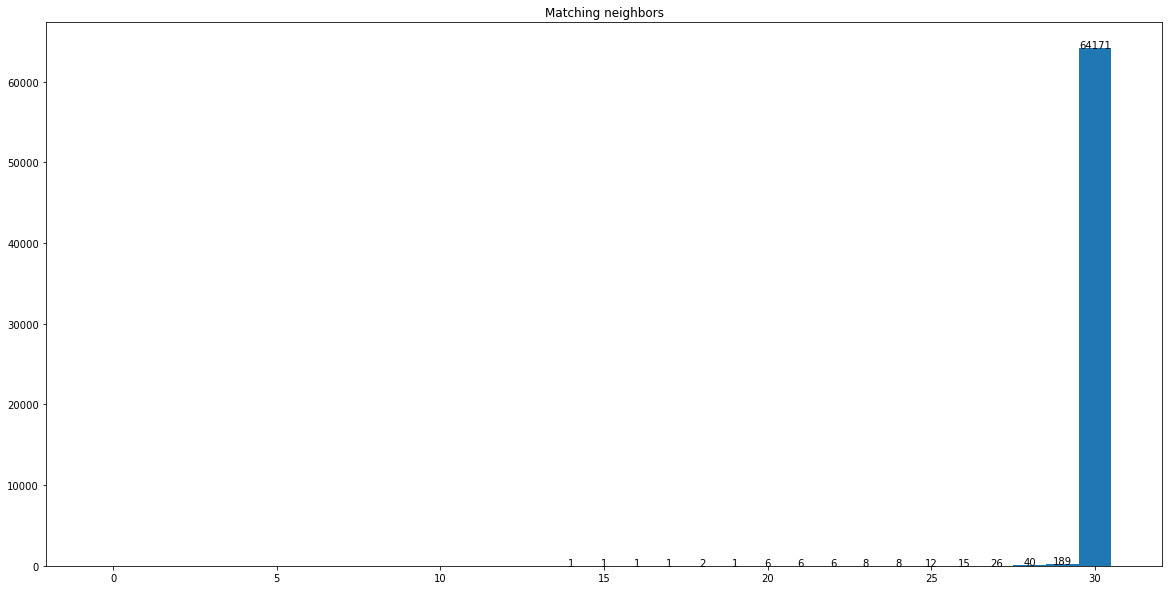

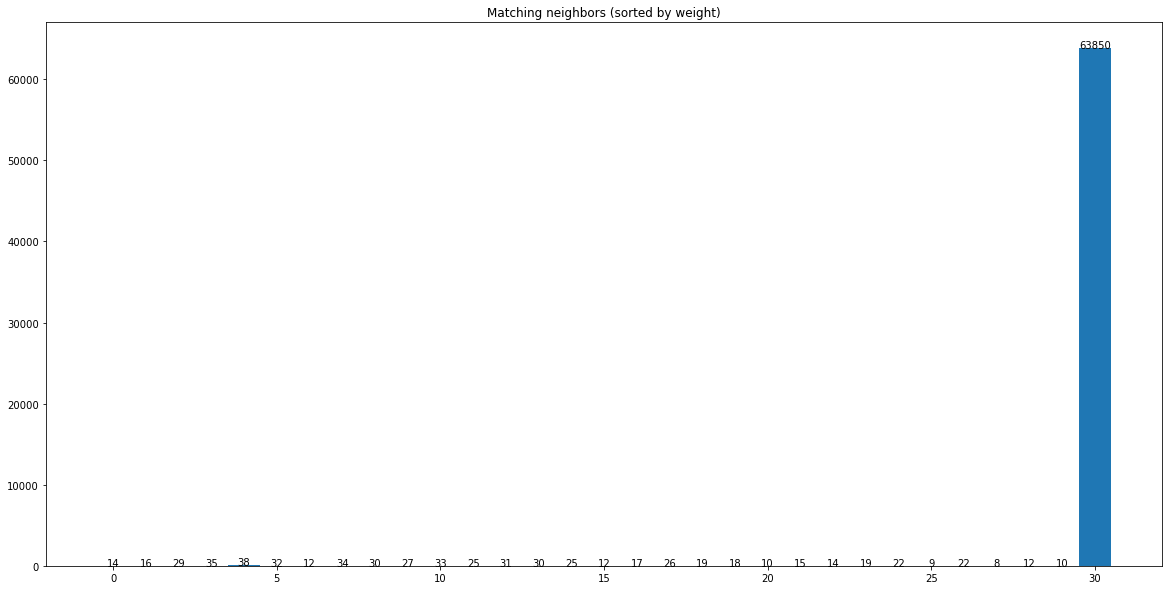

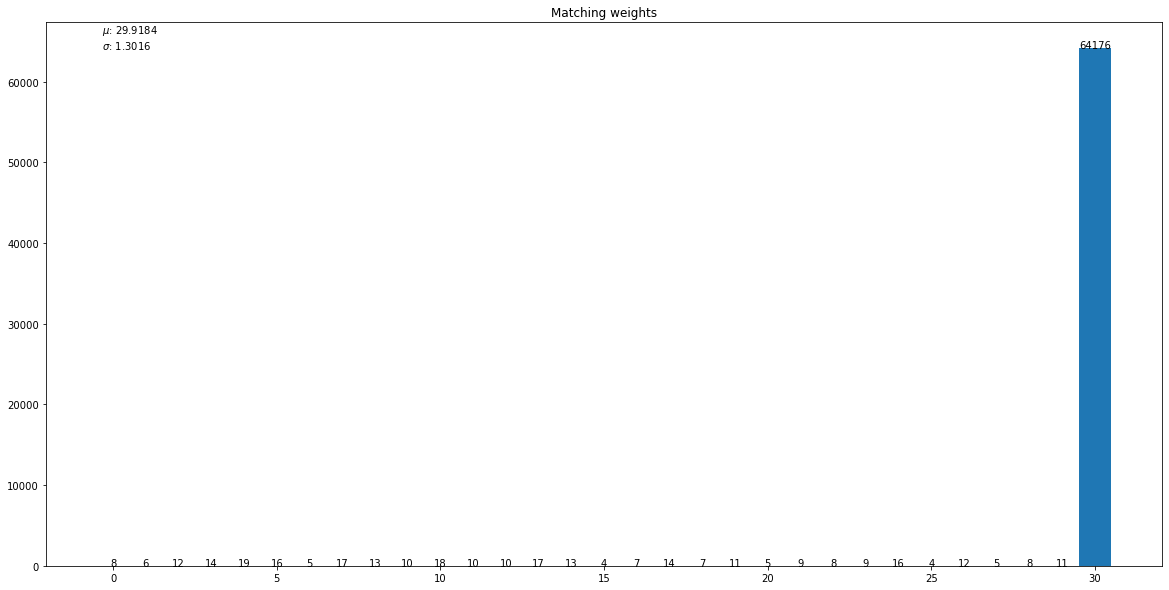

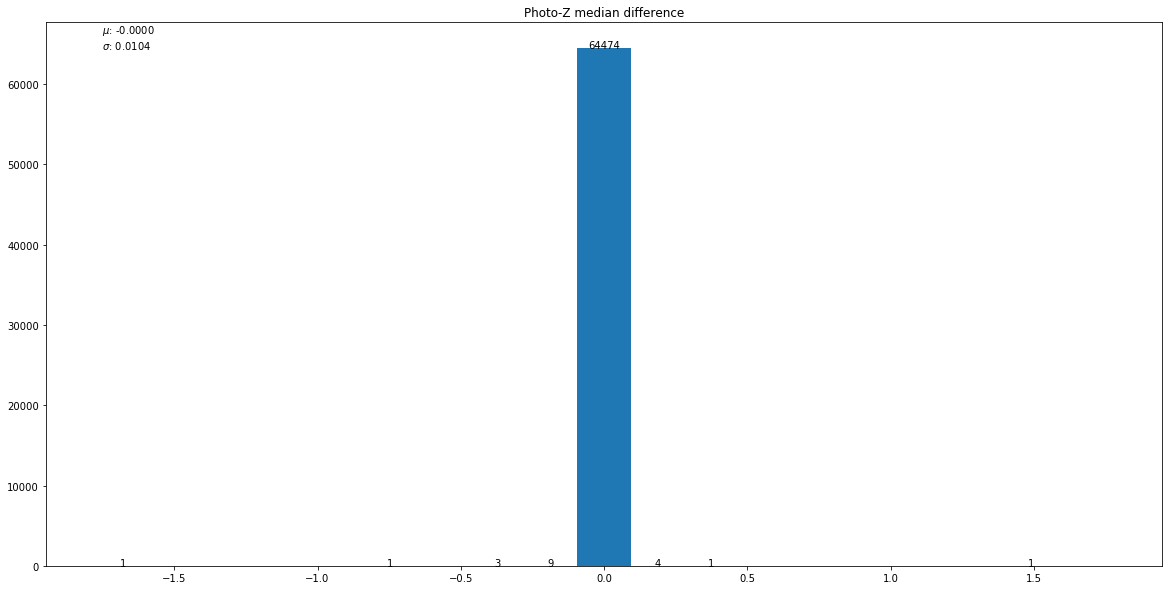

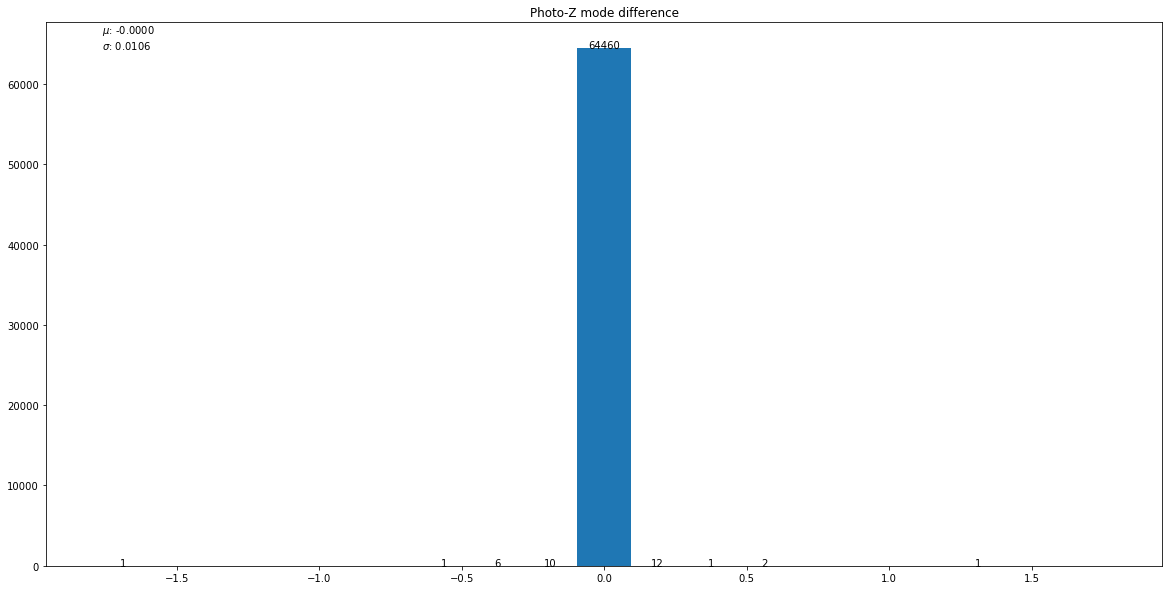

In [19]:
compare('/home/aalvarez/Work/Data/DC2/lognorm005.fits', '/home/aalvarez/Work/Data/DC2/lognorm005_notpruned.fits')

# Tophat

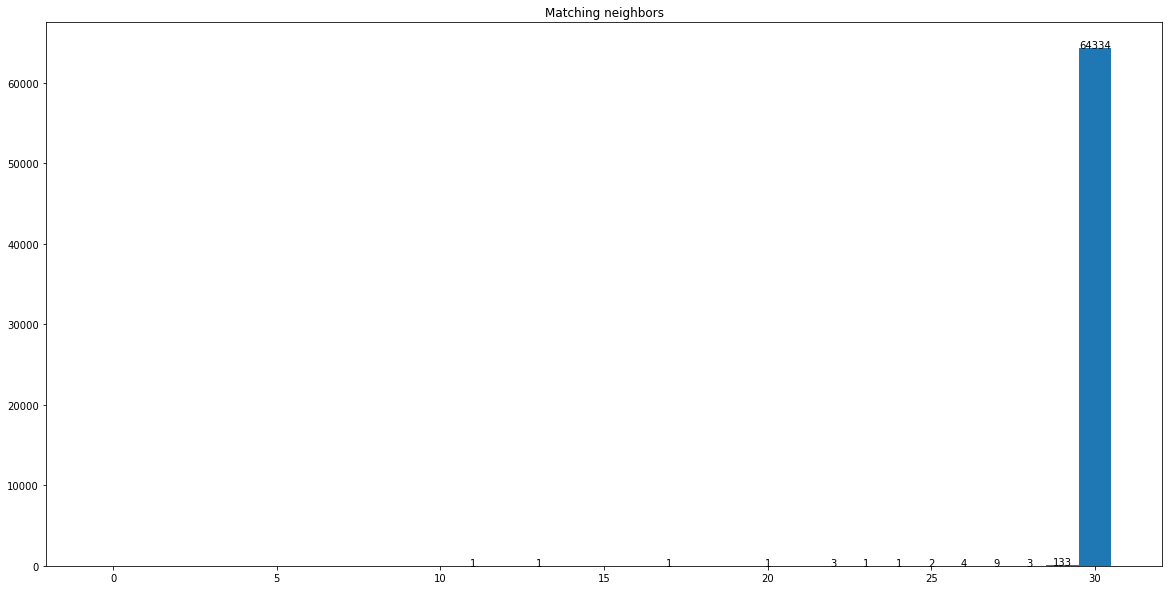

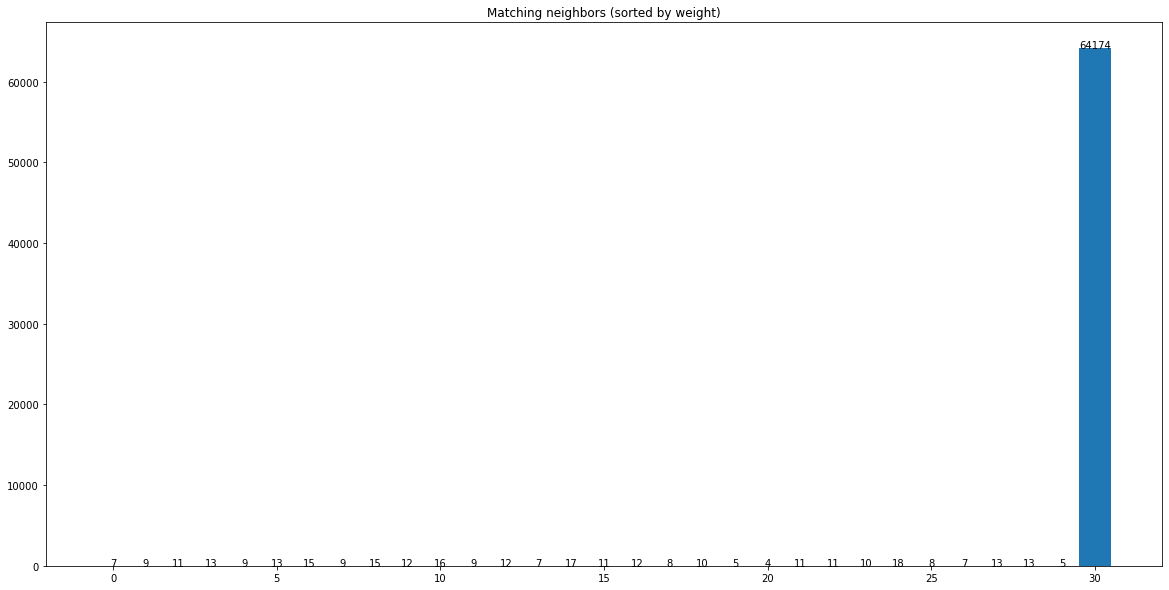

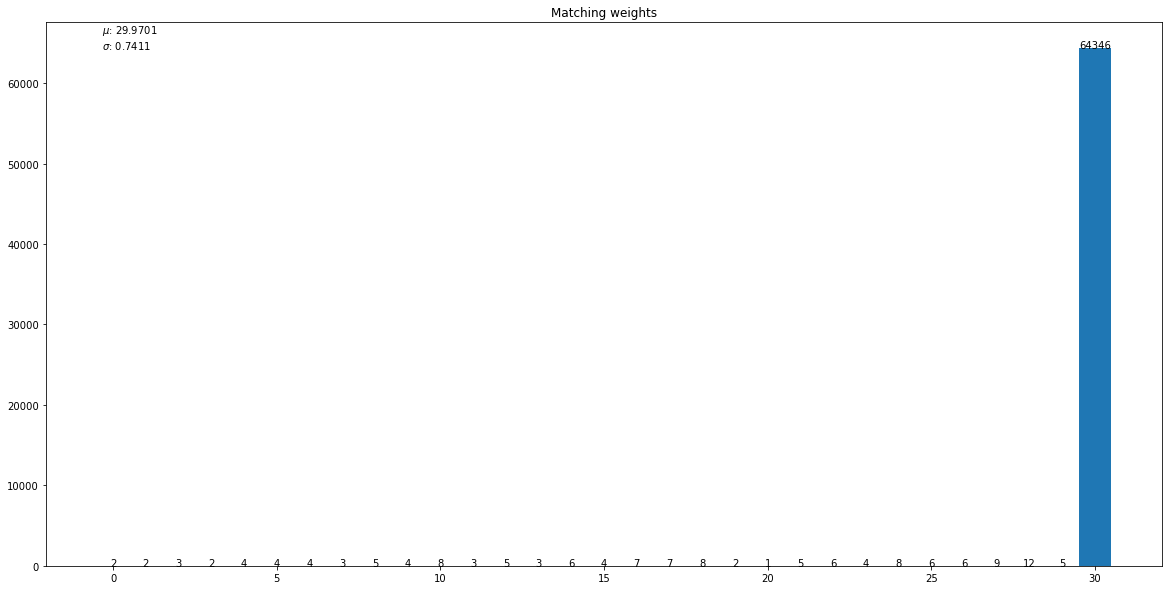

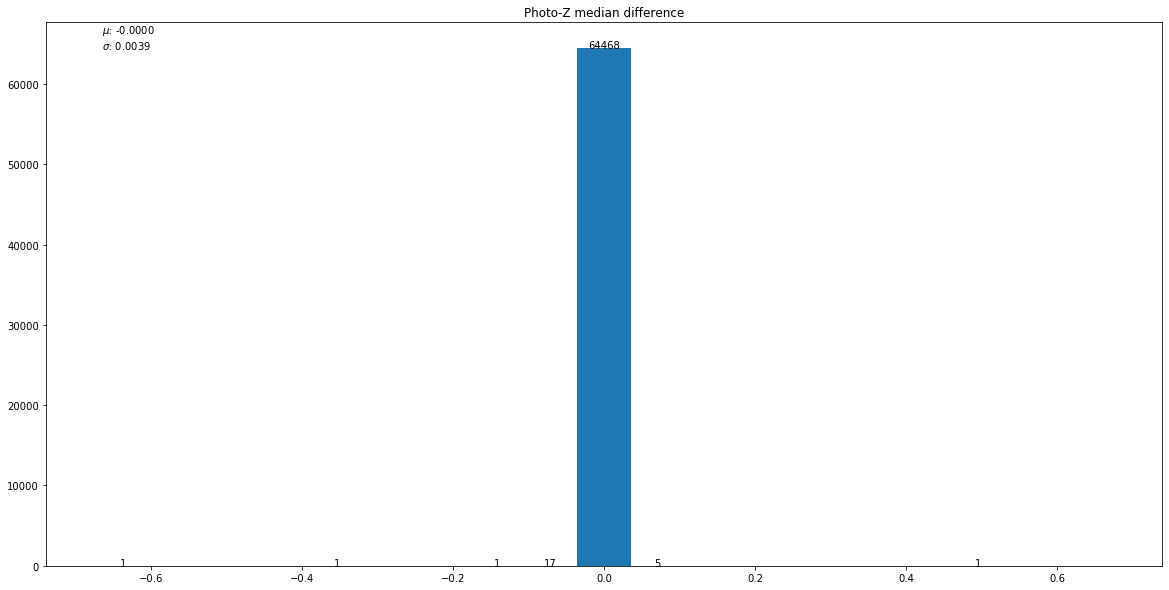

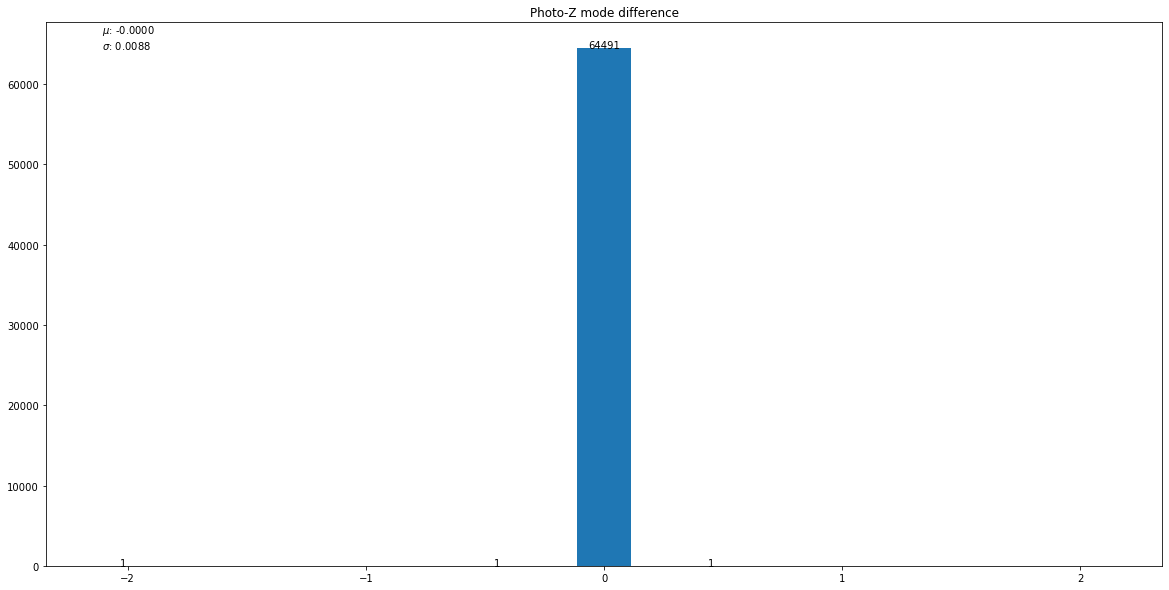

In [20]:
compare('/home/aalvarez/Work/Data/DC2/tophat.fits', '/home/aalvarez/Work/Data/DC2/tophat_notpruned.fits')

# Uniform

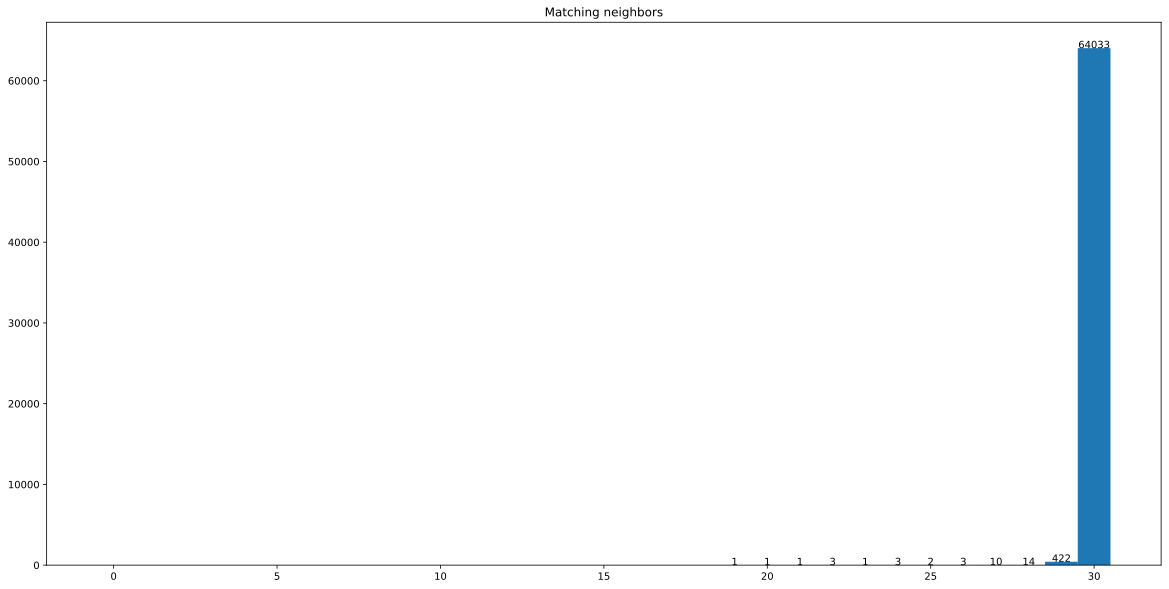

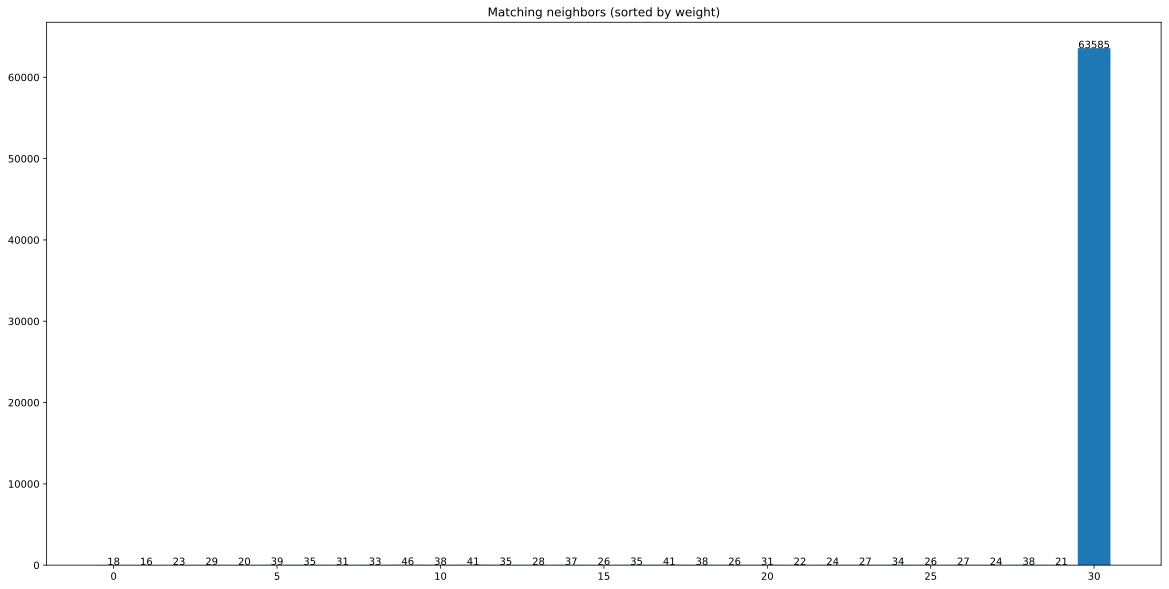

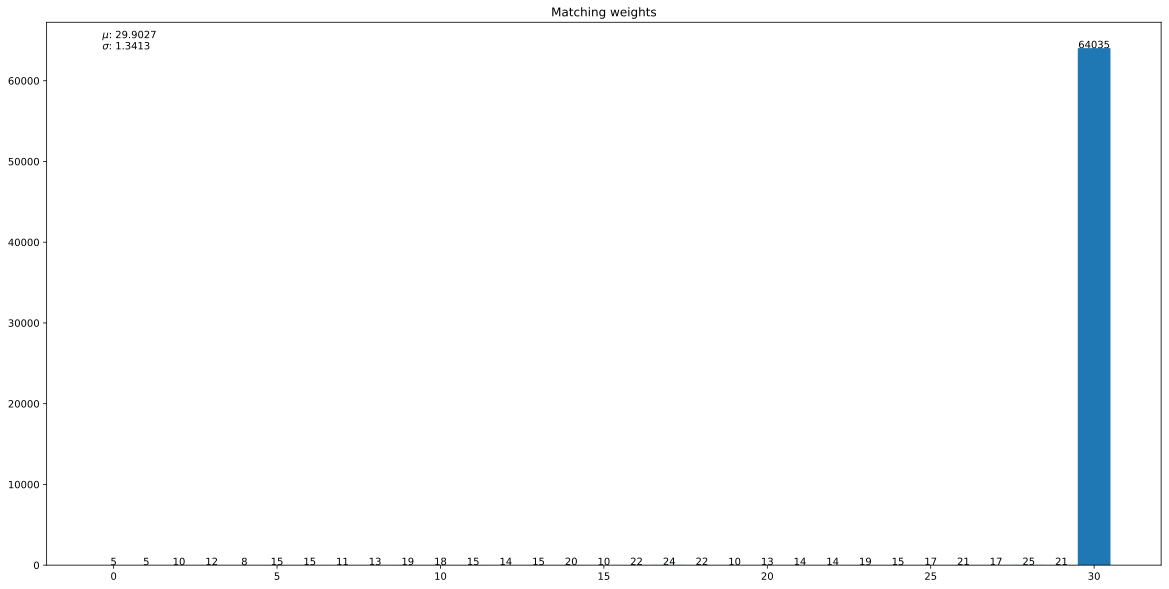

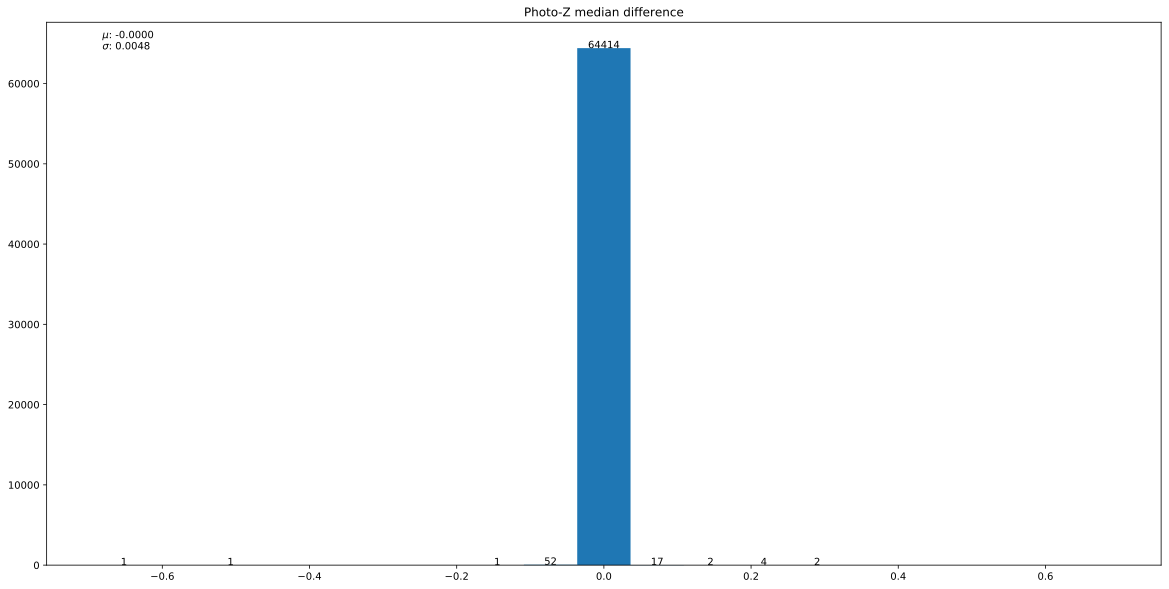

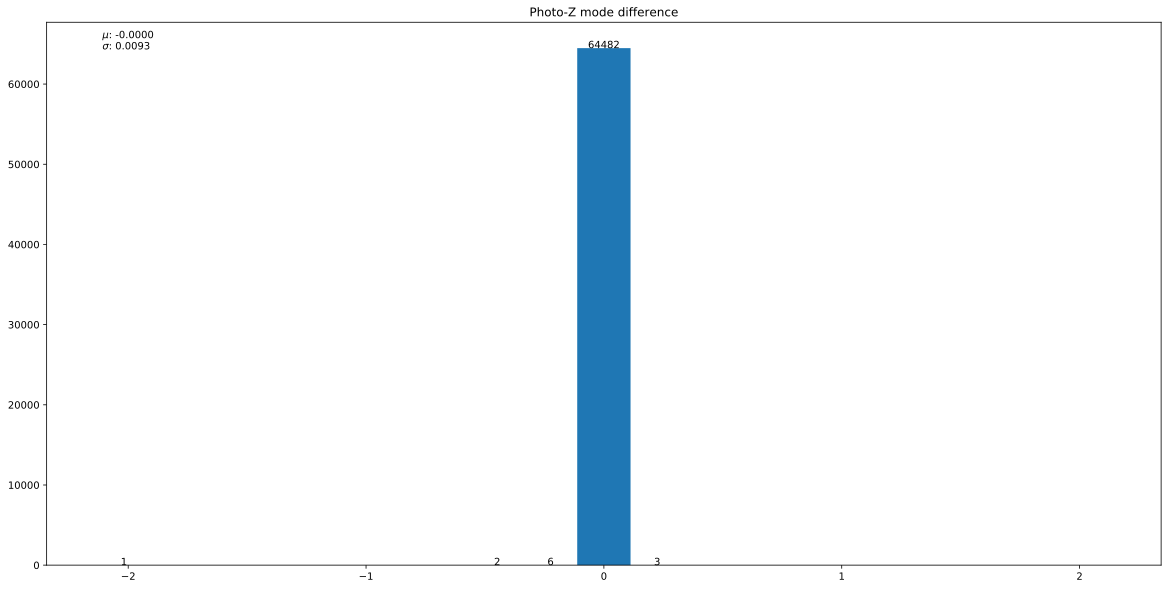

In [23]:
compare('/home/aalvarez/Work/Data/DC2/uniform.fits', '/home/aalvarez/Work/Data/DC2/uniform_notpruned.fits')